In [1]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [3]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master


  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-c3foz3ah
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-c3foz3ah


In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [5]:
#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
#GPU 사용
device = torch.device("cuda:0")
#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

using cached model
using cached model


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import pandas as pd
title_data = pd.read_excel('/content/title_test.xlsx')

In [8]:
title_data.sample(n=10)

,News_num,document,label
64,64,"매억남' 안시후 ""당분간 메이저 코인 위주 투자전략 펼쳐야"" [2021 한경 재테크쇼]",B
187,187,"원희룡 ""코로나 회생 위해 100조 원 투자…생애 첫주택 절반 국가가 부담""",A
297,297,"대덕전자 주가 7%↑…""삼성, 3년간 240조원 신규 투자하고 4만명 고용""",C
322,322,"문 대통령, 도쿄패럴림픽 메달 축하...""선수들에게 아낌없는 박수""",A
298,298,"김 총리 ""자영업자 위해 확보한 지원금 최대한 빨리 지급""",C
687,687,"""뚱뚱하다고요? 요즘 '패션모델'입니다"" 빅사이즈의 시대",C
88,88,"""2015년 실수 반복 안돼""… 아프간 난민에 빗장 걸어 잠그는 독일",A
675,675,"[뉴욕증시 마감] 파월 ""금리인상 멀었다""…3대 지수 일제히 상승",A
684,684,"박지원 ""불법사찰·정치개입 사과...정치 거리두기 실천할 것""",B
184,184,"코로나 기원' 논란 다시 원점?…美정보당국, 바이든에 ""단정 어렵다""",A


In [9]:
title_data.loc[(title_data['label'] == "A"), 'label'] = 0  
title_data.loc[(title_data['label'] == "B"), 'label'] = 1  
title_data.loc[(title_data['label'] == "C"), 'label'] = 2  


In [10]:
title_data.head(5)

,News_num,document,label
0,0,"""지역 환경산업 건전한 육성·발전 앞장""",2
1,1,"""마스크 쓰고, 비누로 손 씻고""…인간 따라하는 침팬지[영상]",2
2,2,"""얀센 백신 추가 접종하면 항체 9배 높아져""",2
3,3,"민주노총, 현대제철에서 대규모 집회 강행...""고발 등 행정조치""",1
4,4,"골드만삭스 ""9월 7일부터 백신 접종자만 건물 출입"" [강영연의 뉴욕오프닝]",2


In [11]:
title_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   News_num  966 non-null    int64 
 1   document  966 non-null    object
 2   label     966 non-null    object
dtypes: int64(1), object(2)
memory usage: 22.8+ KB


In [12]:
title_list = []
for title, label in zip(title_data['document'], title_data['label'])  :
    data = []
    data.append(title)
    data.append(str(label))

    title_list.append(data)

In [13]:
title_list[0]

['"지역 환경산업 건전한 육성·발전 앞장"', '2']

In [14]:
from sklearn.model_selection import train_test_split
                                                         
title_train, title_test = train_test_split(title_list, test_size=0.25, random_state=42)

In [15]:
print(len(title_train))
print(len(title_test))
title_train[0]

724
242


['민주당 "윤희숙, 적반하장 으름장...비판에 겸손해야"', '1']

In [16]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [17]:
max_len = 64
batch_size = 100
warmup_ratio = 0.05
num_epochs = 30
max_grad_norm = 1
log_interval = 200
learning_rate =  0.00007

In [18]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

train = BERTDataset(title_train, 0, 1, tok, max_len, True, False)
test = BERTDataset(title_test, 0, 1, tok, max_len, True, False)

using cached model


In [19]:
train[0]

(array([   2, 2176,  518, 3601, 7993, 6642,  517,   46, 3996, 6286, 7782,
        7178,  517, 7074, 6117, 7178,  517,   54,  517,   54,  517,   54,
        2542, 6896,  952, 6616, 7852,  518,    3,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(29, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 1)

In [20]:
train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [21]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=3,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)


In [22]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

In [23]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 1.1753336191177368 train acc 0.32
epoch 1 train acc 0.3685416666666667


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 1 test acc 0.4920634920634921


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.9591029286384583 train acc 0.58
epoch 2 train acc 0.5260416666666666


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 2 test acc 0.4920634920634921


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.9627426862716675 train acc 0.58
epoch 3 train acc 0.5477083333333334


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 3 test acc 0.41825396825396827


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 1.0412187576293945 train acc 0.48
epoch 4 train acc 0.5552083333333334


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 4 test acc 0.42365079365079367


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.9680321216583252 train acc 0.57
epoch 5 train acc 0.598125


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 5 test acc 0.5153968253968254


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.8958242535591125 train acc 0.59
epoch 6 train acc 0.6254166666666666


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 6 test acc 0.5007936507936508


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.7714162468910217 train acc 0.64
epoch 7 train acc 0.7008333333333334


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 7 test acc 0.5287301587301587


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.665382444858551 train acc 0.73
epoch 8 train acc 0.79625


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 8 test acc 0.5466666666666667


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.47315579652786255 train acc 0.84
epoch 9 train acc 0.8685416666666667


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 9 test acc 0.5261904761904762


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.45420166850090027 train acc 0.83
epoch 10 train acc 0.8875000000000001


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 10 test acc 0.5028571428571429


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.3551495373249054 train acc 0.87
epoch 11 train acc 0.9175


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 11 test acc 0.5692063492063492


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 0.2815636992454529 train acc 0.91
epoch 12 train acc 0.95


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 12 test acc 0.5253968253968254


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 0.3903343081474304 train acc 0.83
epoch 13 train acc 0.93875


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 13 test acc 0.555873015873016


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 0.2847789227962494 train acc 0.9
epoch 14 train acc 0.9650000000000001


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 14 test acc 0.5604761904761905


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 0.23986603319644928 train acc 0.93
epoch 15 train acc 0.975


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 15 test acc 0.5771428571428572


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 16 batch id 1 loss 0.10146617144346237 train acc 0.98
epoch 16 train acc 0.9725


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 16 test acc 0.5671428571428571


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 17 batch id 1 loss 0.14246663451194763 train acc 0.95
epoch 17 train acc 0.9725


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 17 test acc 0.555873015873016


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 18 batch id 1 loss 0.14412547647953033 train acc 0.95
epoch 18 train acc 0.98


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 18 test acc 0.5525396825396826


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 19 batch id 1 loss 0.1554916352033615 train acc 0.96
epoch 19 train acc 0.9750000000000001


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 19 test acc 0.5625396825396826


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 20 batch id 1 loss 0.16154609620571136 train acc 0.95
epoch 20 train acc 0.98


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 20 test acc 0.5625396825396826


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 21 batch id 1 loss 0.10748705267906189 train acc 0.96
epoch 21 train acc 0.9812500000000001


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 21 test acc 0.5592063492063492


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 22 batch id 1 loss 0.08854839205741882 train acc 0.96
epoch 22 train acc 0.97875


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 22 test acc 0.5446031746031745


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 23 batch id 1 loss 0.06347127258777618 train acc 0.97
epoch 23 train acc 0.9825


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 23 test acc 0.5479365079365079


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 24 batch id 1 loss 0.0480860136449337 train acc 0.98
epoch 24 train acc 0.9824999999999999


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 24 test acc 0.5512698412698412


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 25 batch id 1 loss 0.0398072712123394 train acc 0.98
epoch 25 train acc 0.98


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 25 test acc 0.5458730158730158


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 26 batch id 1 loss 0.04793589562177658 train acc 0.96
epoch 26 train acc 0.9775


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 26 test acc 0.5458730158730158


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 27 batch id 1 loss 0.03587949648499489 train acc 0.99
epoch 27 train acc 0.9837500000000001


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 27 test acc 0.5538095238095238


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 28 batch id 1 loss 0.04422414302825928 train acc 0.98
epoch 28 train acc 0.9849999999999999


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 28 test acc 0.5492063492063493


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 29 batch id 1 loss 0.03450360149145126 train acc 0.99
epoch 29 train acc 0.9862500000000001


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 29 test acc 0.5446031746031745


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 30 batch id 1 loss 0.04646732285618782 train acc 0.97
epoch 30 train acc 0.9775


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 30 test acc 0.5446031746031745


In [34]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        test_eval = []
        for i in out:
            
            logits=i
            logits = np.round(logits.detach().cpu().numpy(),2)
            
            for idx , j in enumerate(logits):
                logits[idx] = np.exp(j)
            tot_e = sum(logits)
            logits = (logits/tot_e) * 100
            #print(type(logits))
            if np.argmax(logits) == 0:
                test_eval.append("판단유보")
            elif np.argmax(logits) == 1:
                test_eval.append("책임회피")
            else : test_eval.append("선정주의")

        
       # print(">> 이타이틀은 판단유보 {:.2f}%, 책임회피 {:.2f}%, 선정주의 {:.2f}% 으로 측정되어 {}유형의 따옴표입니다".format(logits[0],logits[1],logits[2],test_eval[0]))
        return logits
        

using cached model


In [25]:
test_data = pd.read_excel('/content/test.xlsx')

In [26]:
test_list = []
for title in test_data['title'] :
    data = []
    data.append(title)

    test_list.append(data)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


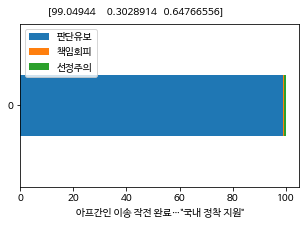

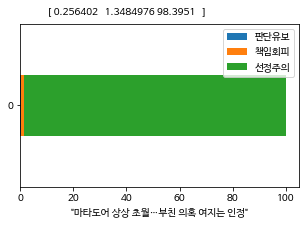

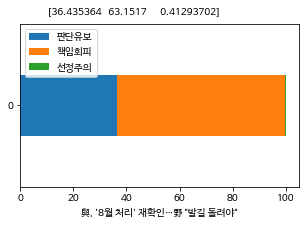

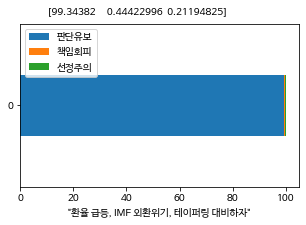

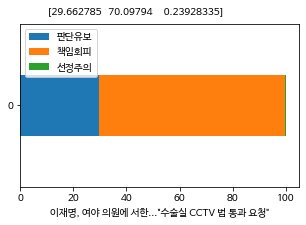

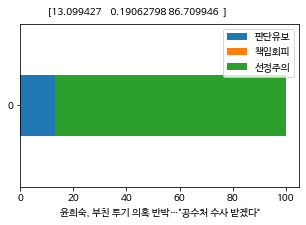

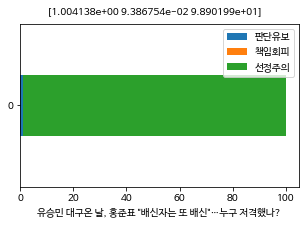

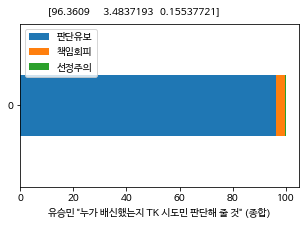

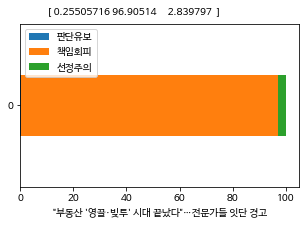

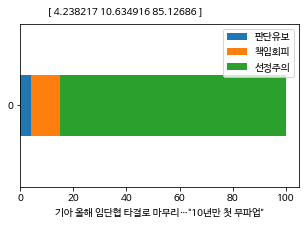

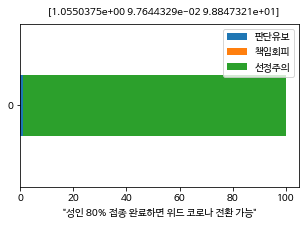

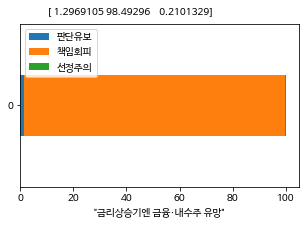

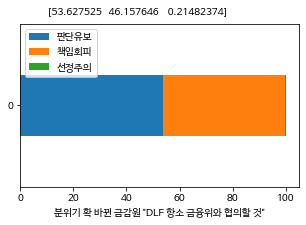

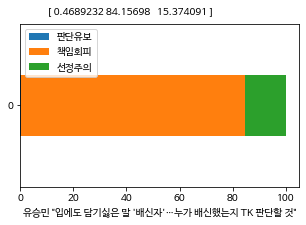

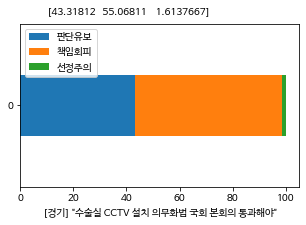

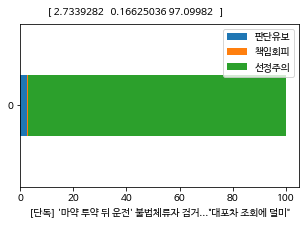

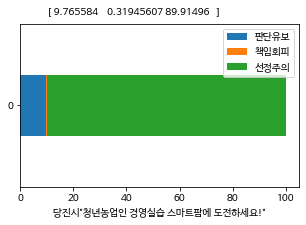

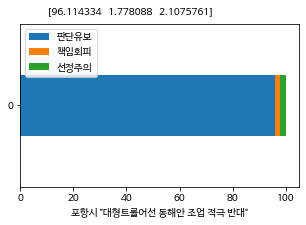

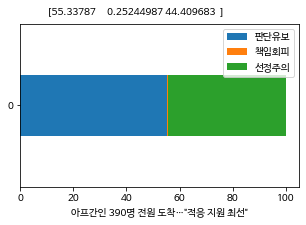

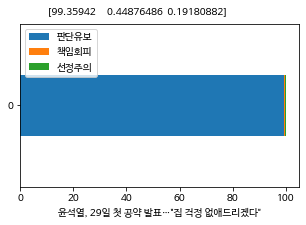

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
for i in range(len(test_list)):
  dict_test = {"판단유보" : predict(test_list[i][0])[0],"책임회피": predict(test_list[i][0])[1],"선정주의":predict(test_list[i][0])[2]}
  df=pd.DataFrame([dict_test])

  ax = df.plot(kind="barh",stacked=True,figsize=(5,3),width=0.3)
  plt.text(10,0.45,s=predict(test_list[i][0]))
  plt.rc('font', family='NanumBarunGothic') 

  plt.xlabel(test_list[i][0])
  plt.show()
  print('\n')

In [29]:
for i in range(len(test_list)):
  print(test_list[i][0])
  predict(test_list[i][0])
  print('\n')

아프간인 이송 작전 완료…"국내 정착 지원"


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


<class 'numpy.ndarray'>
>> 이타이틀은 판단유보 99.05%, 책임회피 0.30%, 선정주의 0.65% 으로 측정되어 판단유보유형의 따옴표입니다


"마타도어 상상 초월…부친 의혹 여지는 인정"
<class 'numpy.ndarray'>
>> 이타이틀은 판단유보 0.26%, 책임회피 1.35%, 선정주의 98.40% 으로 측정되어 선정주의유형의 따옴표입니다


與, '8월 처리' 재확인…野 "발길 돌려야"
<class 'numpy.ndarray'>
>> 이타이틀은 판단유보 36.44%, 책임회피 63.15%, 선정주의 0.41% 으로 측정되어 책임회피유형의 따옴표입니다


"환율 급등, IMF 외환위기, 테이퍼링 대비하자"
<class 'numpy.ndarray'>
>> 이타이틀은 판단유보 99.34%, 책임회피 0.44%, 선정주의 0.21% 으로 측정되어 판단유보유형의 따옴표입니다


이재명, 여야 의원에 서한..."수술실 CCTV 법 통과 요청"
<class 'numpy.ndarray'>
>> 이타이틀은 판단유보 29.66%, 책임회피 70.10%, 선정주의 0.24% 으로 측정되어 책임회피유형의 따옴표입니다


윤희숙, 부친 투기 의혹 반박…"공수처 수사 받겠다"
<class 'numpy.ndarray'>
>> 이타이틀은 판단유보 13.10%, 책임회피 0.19%, 선정주의 86.71% 으로 측정되어 선정주의유형의 따옴표입니다


유승민 대구온 날, 홍준표 "배신자는 또 배신"…누구 저격했나?
<class 'numpy.ndarray'>
>> 이타이틀은 판단유보 1.00%, 책임회피 0.09%, 선정주의 98.90% 으로 측정되어 선정주의유형의 따옴표입니다


유승민 "누가 배신했는지 TK 시도민 판단해 줄 것" (종합)
<class 'numpy.ndarray'>
>> 이타이틀은 판단유보 96.36%, 책임회피 3.48%, 선정주의 0.16% 으로 측정되어 판단유보유형의 따옴표입니다


"부동산 '영끌·빚투' 시대 끝났다"…전문가들 잇